## <font color="880000"> Solow Growth Model </font>

Factor accumulation:

>(1) $ \frac{dL_t}{dt} = nL_t $

>(2) $ \frac{dE_t}{dt} = gE_t $

>(3) $ \frac{dK_t}{dt} = sY_t - δK_t $

Production function:

>(4) $ Y_t = K_t^α(L_tE_t)^{(1-α)} $

Definition of capital-output ratio:

>(5) $ κ_t = \frac{K_t}{Y_t} $

Solving for the rate of change of the capital-output ratio:

>(6) $ Y_t = κ_t^{(α/(1-α))}(L_tE_t) $

>(7) $ \frac{1}{K_t}\frac{dK_t}{dt} = \frac{s}{κ_t} - δ $

>(8) $ \frac{1}{Y_t}\frac{dY_t}{dt} = α \left( \frac{1}{K_t}\frac{dK_t}{dt} \right) + (1-α)(n+g) $

>(9) $ \frac{1}{κ_t}\frac{dκ_t}{dt} = \frac{1}{K_t}\frac{dK_t}{dt} - α \left( \frac{1}{K_t}\frac{dK_t}{dt} \right) - (1-α)(n+g) $

>(10) $ \frac{1}{κ_t}\frac{dκ_t}{dt} =  (1- α) \left( \frac{1}{K_t}\frac{dK_t}{dt}  \right) - (1-α)(n+g) $

>(11) $ \frac{1}{κ_t}\frac{dκ_t}{dt} =  (1- α) \left( \frac{s}{κ_t} - δ  \right) - (1-α)(n+g) $

>(12) $ \frac{dκ_t}{dt} =  (1- α) \left( s - (n+g+δ)κ_t  \right) $

Integrating:

>(13) $ κ_t = \frac{s}{n+g+δ} + e^{-(1-α)(n+g+δ)t} \left[ κ_0 - \frac{s}{n+g+δ}  \right]   $

Discretizing for a difference model:

>(14) $ κ_{t+1} = κ_t + \left[ \frac{1 - e^{-(1-α)(n+g+δ)}}{n+g+δ} \right] \left( s - (n+g+δ)κ_t  \right) $

>(15) $ 1 - α' = (1 - α) [ 1 - \frac{(1-α)(n+g+δ)}{2} + \frac{(1-α)^2(n+g+δ)^2}{6} - ... ]   $

>(16) $ κ_{t+1} = κ_t + (1- α') \left( s - (n+g+δ)κ_t  \right)  $

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [68]:
class Solow_delong:
    
    """ 
    Implements the Solow growth model calculation of the 
    capital-output ratio κ and other model variables
    using the update rule:
    
    κ_{t+1} = κ_t + ( 1 - α) ( s - (n+g+δ)κ_t )
    
    Built upon and modified from Stachurski-Sargeant 
    <https://quantecon.org> class **Solow** 
    <https://lectures.quantecon.org/py/python_oop.html>
    """
    
    def __init__(self, n=0.01,              # population growth rate
                       s=0.20,              # savings rate
                       δ=0.03,              # depreciation rate
                       α=1/3,               # share of capital
                       g=0.01,              # productivity
                       κ=0.2/(.01+.01+.03), # current capital-labor ratio
                       E=1.0,               # current efficiency of labor
                       L=1.0):              # current labor force  

        self.n, self.s, self.δ, self.α, self.g = n, s, δ, α, g
        self.κ, self.E, self.L = κ, E, L
        self.Y = self.κ**(self.α/(1-self.α))*self.E*self.L
        self.K = self.κ * self.Y
        self.y = self.Y/self.L
        self.α1 = 1-((1-np.exp((self.α-1)*(self.n+self.g+self.δ)))/(self.n+self.g+self.δ))
        self.initdata = vars(self).copy()
        
    def calc_next_period_kappa(self):
        "Calculate the next period capital-output ratio."
        # Unpack parameters (get rid of self to simplify notation)
        n, s, δ, α1, g, κ= self.n, self.s, self.δ, self.α1, self.g, self.κ
        # Apply the update rule
        return (κ + (1 - α1)*( s - (n+g+δ)*κ ))

    def calc_next_period_E(self):
        "Calculate the next period efficiency of labor."
        # Unpack parameters (get rid of self to simplify notation)
        E, g = self.E, self.g
        # Apply the update rule
        return (E * np.exp(g))

    def calc_next_period_L(self):
        "Calculate the next period labor force."
        # Unpack parameters (get rid of self to simplify notation)
        n, L = self.n, self.L
        # Apply the update rule
        return (L*np.exp(n))

    def update(self):
        "Update the current state."
        self.κ =  self.calc_next_period_kappa()
        self.E =  self.calc_next_period_E()
        self.L =  self.calc_next_period_L()
        self.Y = self.κ**(self.α/(1-self.α))*self.E*self.L
        self.K = self.κ * self.Y
        self.y = self.Y/self.L

    def steady_state(self):
        "Compute the steady state value of the capital-output ratio."
        # Unpack parameters (get rid of self to simplify notation)
        n, s, δ, g = self.n, self.s, self.δ, self.g
        # Compute and return steady state
        return (s /(n + g + δ))

    def generate_sequence(self, t, var = 'κ', init = True):
        "Generate and return time series of selected variable. Variable is κ by default. Start from t=0 by default."
        path = []
        
        # initialize data 
        if init == True:
            for para in self.initdata:
                 setattr(self, para, self.initdata[para])

        for i in range(t):
            path.append(vars(self)[var])
            self.update()
        return path

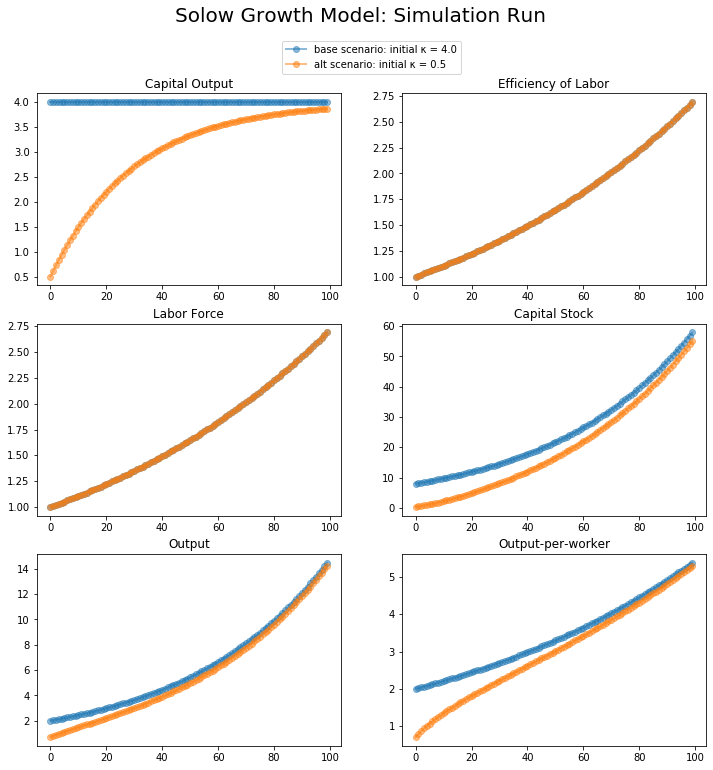

In [62]:
T = 100

s_base = Solow_delong(κ=4.0)
s_base.scenario = "base scenario"
s_alt = Solow_delong(κ=0.5)
s_alt.scenario = "alt scenario"

figcontents = {
        (0,0):('κ','Capital Output'),
        (0,1):('E','Efficiency of Labor'),
        (1,0):('L','Labor Force'),
        (1,1):('K','Capital Stock'),
        (2,0):('Y','Output'),
        (2,1):('y','Output-per-worker')
       }

num_rows, num_cols = 3,2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))
for i in range(num_rows):
    for j in range(num_cols):
        for s in s_base, s_alt:
            lb = f'{s.scenario}: initial κ = {s.initdata["κ"]}'
            axes[i,j].plot(s.generate_sequence(T, var = figcontents[i,j][0]),'o-', lw=2, alpha=0.5, label=lb)
            axes[i,j].set(title=figcontents[i,j][1])

#   global legend
axes[(0,0)].legend(loc='upper center', bbox_to_anchor=(1.1,1.3))
plt.suptitle('Solow Growth Model: Simulation Run', size = 20)
plt.show()    

## <font color="880000"> Solow Growth Model: Capital-Output Ratio as State Variable</font>

<img src="https://tinyurl.com/20190119a-delong" width="300" style="float:right" />

### <font color="000088">Catch Our Breath—Further Notes:</font>

<br clear="all" />

----

* Weblog Support <https://github.com/braddelong/LS2019/blob/master/2019-08-08-Sargent-Stachurski.ipynb>
* nbViewer <https://nbviewer.jupyter.org/github/braddelong/LS2019/blob/master/2019-08-08-Sargent-Stachurski.ipynb>

&nbsp;

----

&nbsp;

----

### Change Log

**2019-07-25** by DeLong: Playing with Sargent and Stachurowski's QuantEcon: <https://quantecon.org>

&nbsp;

----

__2019-08-05__ by Yinshan, list of changes made:

1. Merged `generate_x_sequence` into one method
2. Added initializing steps to `generate_sequence` method to eliminate the need of redefining instance for every plot
2. Removed unnecessary `import` commands
2. Changed comment to docstring for the class `SolowKappa`
2. Changed $\alpha$ to $\alpha'$ in calculation of $\kappa$

    Effect: slight change in $\kappa$ value for each time period (converge slower to the steady state), but no change in general convergence behavior
3.  Modified unpacking commands for self variables, removed unused ones and added used ones

----

**2019-08-07** by delong: list of changes made:

1. Named `s_base` and `s_alt` cases
2. Added the six-panel summary graph

----

**2019-08-08** by delong: list of changes made:

1. Renamed `SolowKappa` class to `Solow_delong`
2. Added info about Stachurski-Sargeant QuantEcon <http:quantecon.org> to the docstring.

----


**2019-08-08** by Yinshan: list of changes made:

1. Modified six-panel summary code, added loop and `figcontents` dictionary
2. Changed six-panel summary graph legend to global, added subtitles to subplots
3. Added illustration on  
```
self.initdata = vars(self).copy()
```
and 
```
if init == True:
     for para in self.initdata:
         setattr(self, para, self.initdata[para])
```

----

&nbsp;

&nbsp;

## Appendices

**Illustration on selected syntaxes:**
1. `self.initdata = vars(self).copy()` 
    
   `vars(self)` returns a dictionary containing data attributes of the instance `self`. 
   
   More technically speaking, for every module object in Python, the read-only attribute `__dict__` returns the dictionary used to implement the module’s namespace. 
   
   In our case, `vars(self)` gives us all initial data attributes we just defined. `self.initdata = vars(self).copy()`  copies the returned dictionary and stores it for future use in the initializing step of `generate_sequence` method. 
   
2.  
```
if init == True:
        for para in self.initdata:
            setattr(self, para, self.initdata[para])
```
The above steps initialize all parameters stored in `self.initdata`. `setattr` is used to assigns a value to the attribute, provided the object allows it. Usually `setattr(object,name,value)` is equivalent to `object.name = value`. 

    However, in our case, we need to get attributes dynamically named in a loop, depending on current `para`. `setattr` gives a handy solution. The usual `=` way of assigning value would return an error.


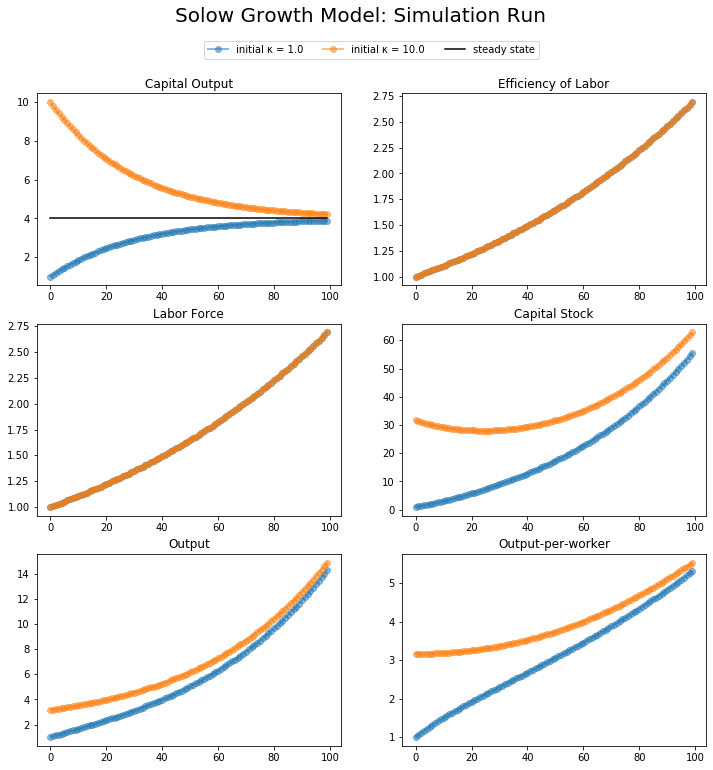

In [63]:
# change starting points
s_base = Solow_delong(κ=1.0)
s_alt = Solow_delong(κ=10.0)

# reproduce plots
num_rows, num_cols = 3,2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))
for s in s_base, s_alt:
    for i in range(num_rows):
        for j in range(num_cols):
            lb = f'initial κ = {s.initdata["κ"]}'
            axes[i,j].plot(s.generate_sequence(T, var = figcontents[i,j][0]),'o-', lw=2, alpha=0.5, label=lb)
            axes[i,j].set(title=figcontents[i,j][1])

#   add steady state to capital output        
axes[(0,0)].plot([s_base.steady_state()]*T, 'k-', label='steady state')

#   global legend
axes[(0,0)].legend(loc='upper center', bbox_to_anchor=(1.1,1.3),ncol=3)

plt.suptitle('Solow Growth Model: Simulation Run', size = 20)
plt.show()    

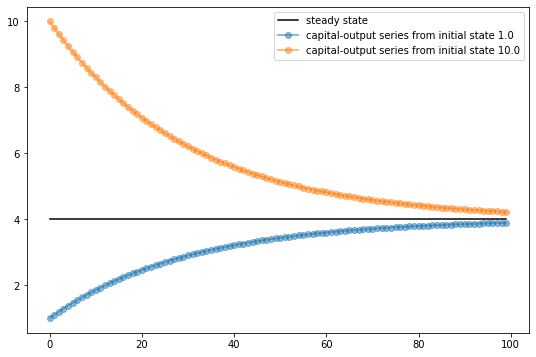

In [5]:
T = 100

s_base = Solow_delong(κ=1.0)
s_alt = Solow_delong(κ=10.0)

fig, ax = plt.subplots(figsize=(9, 6))

# Plot the common steady-state value of the capital-output ratio
ax.plot([s_base.steady_state()]*T, 'k-', label='steady state')

# Plot time series for each economy
for s in s_base, s_alt:
    lb = f'capital-output series from initial state {s.initdata["κ"]}'
    ax.plot(s.generate_sequence(T), 'o-', lw=2, alpha=0.5, label=lb)
    

ax.legend()
plt.show()

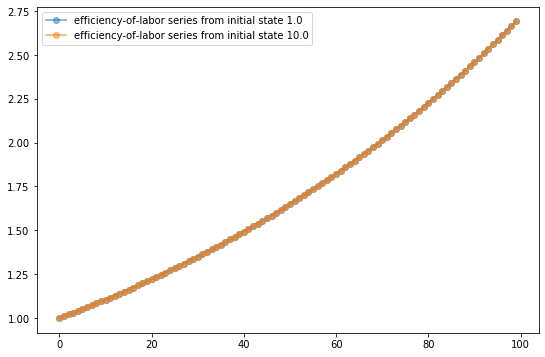

In [6]:
fig, ax = plt.subplots(figsize=(9, 6))

# Plot time series for each economy
for s in s_base, s_alt:
    lb = f'efficiency-of-labor series from initial state {s.initdata["κ"]}'
    ax.plot(s.generate_sequence(T, var='E'), 'o-', lw=2, alpha=0.5, label=lb)
    

ax.legend()
plt.show()

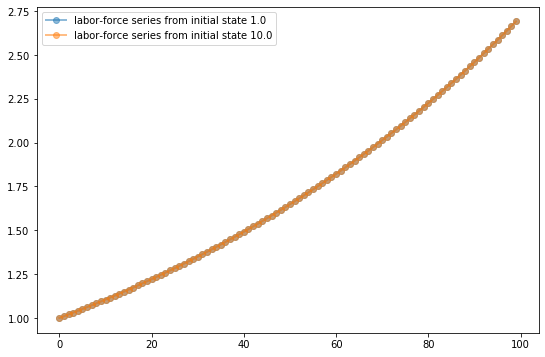

In [7]:
fig, ax = plt.subplots(figsize=(9, 6))

# Plot time series for each economy
for s in s_base, s_alt:
    lb = f'labor-force series from initial state {s.initdata["κ"]}'
    ax.plot(s.generate_sequence(T, var = 'L'), 'o-', lw=2, alpha=0.5, label=lb)
    
ax.legend()
plt.show()

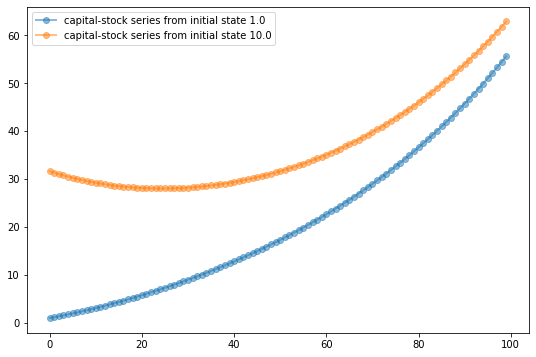

In [8]:
fig, ax = plt.subplots(figsize=(9, 6))

# Plot time series for each economy
for s in s_base, s_alt:
    lb = f'capital-stock series from initial state {s.initdata["κ"]}'
    ax.plot(s.generate_sequence(T, var = 'K'), 'o-', lw=2, alpha=0.5, label=lb)
    

ax.legend()
plt.show()

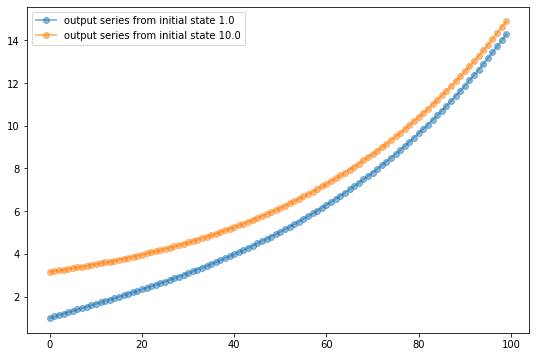

In [9]:
fig, ax = plt.subplots(figsize=(9, 6))

# Plot time series for each economy
for s in s_base, s_alt:
    lb = f'output series from initial state {s.initdata["κ"]}'
    ax.plot(s.generate_sequence(T, var = 'Y'), 'o-', lw=2, alpha=0.5, label=lb)
    

ax.legend()
plt.show()

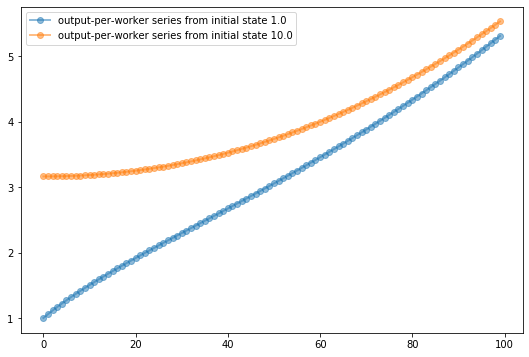

In [10]:
fig, ax = plt.subplots(figsize=(9, 6))

for s in s_base, s_alt:
    lb = f'output-per-worker series from initial state {s.initdata["κ"]}'
    ax.plot(s.generate_sequence(T, var = 'y'), 'o-', lw=2, alpha=0.5, label=lb)
ax.legend()

plt.show()